In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import pickle
%matplotlib inline
from pathlib import Path

from imblearn.over_sampling import SMOTE
from tqdm import tqdm
# SK-Learn related libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

C:\Users\Chern\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
os.chdir(Path().absolute())

### Data Loading  
1. Read APS failure training set, skip first 20 description rows. 
2. Replace string 'na' to actual NA

In [3]:
# read dataset, skip first 20 rows description, replace 'na' to NA
df = pd.read_csv('aps_failure_training_set.csv', sep=',', skiprows=20, na_values=['na'])
df_test = pd.read_csv('aps_failure_test_set.csv', sep=',', skiprows=20, na_values=['na'])
# create a backup original dataframe
df_ori = df.copy()
df_test_ori = df_test.copy()

### Data Exploration & Preprocessing Phase  
1. Explore dataframe summary (min, max, median, etc..)
    - All variables are numeric, except target class.
2. Check target class for missing values :  
    - There is no missing value in target class, however it is highly imbalance.  
    Need to be careful if prediction is predicting 1 class only.
    - Negative class is ~98.33%.
    - Transform target class to binary (Label Encoding)
3. Check predictors for missing values :  
    - There is 42 features with >5% missing values
    - There is 7 features with **>70%** missing values
    - This need to be addressed before training by dropping/imputing
4. Explore pairwise relationship between predictors

In [4]:
# 1. Dataframe summary
print('Total columns = {}'.format(df.shape[1]))
print('Total numeric columns = {}'.format(df.select_dtypes(include='number').shape[1]))
df.describe()

Total columns = 171
Total numeric columns = 170


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


target class, missing : 0
target distribution : ['neg' 'pos'], [59000  1000]


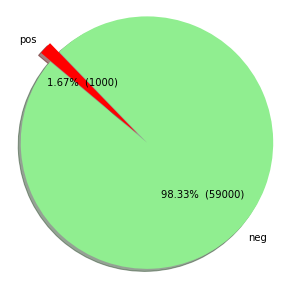

In [5]:
# 2. Target variable exploration
target_var = df["class"].value_counts()

# Data to plot
labels = target_var.index
values = target_var.values
colors = ['lightgreen', 'red']
explode = [0 if i=='neg' else 0.1 for i in target_var.index]

# Create value & percentage label
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Transform target variable to binary
df['class'] = LabelEncoder().fit_transform(df['class'].values)


missing_target = df["class"].isna().sum()
print('target class, missing : {}'.format(missing_target))
print('target distribution : {0}, {1}'.format(labels.values, values))

# Plot
rcParams['figure.figsize'] = 5, 5
plt.pie(values, labels = labels, explode = explode,
        colors = colors, autopct = make_autopct(values), shadow = True, startangle = 140)
plt.axis('equal')
plt.show()

Predictors count : 170
Predictors with >5% missing : 42
Predictors with >20% missing : 24
Predictors with >50% missing : 8
Predictors with >70% missing : 7
Predictors with >90% missing : 0


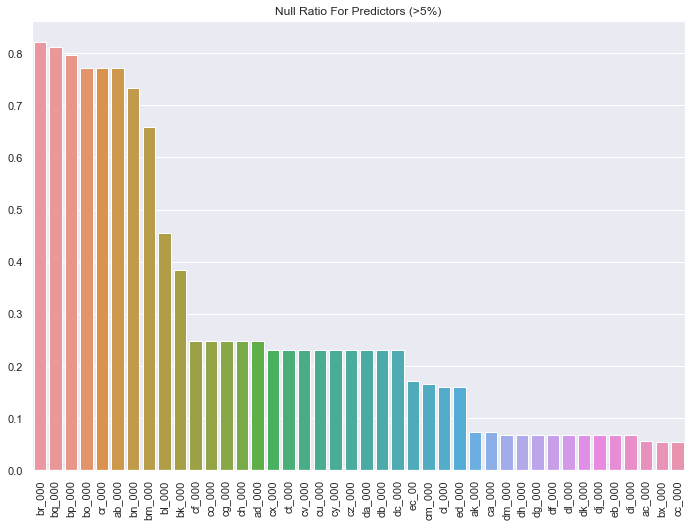

In [6]:
# 3A. Feature variables exploration
missing_predictor = (df.loc[:,df.columns != 'class'].isnull().sum() /  \
                        df.loc[:,df.columns != 'class'].shape[0]).sort_values(ascending=False)

# set seaborn plot figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})

splt = sns.barplot(x = missing_predictor[missing_predictor.values > 0.05].index.values,  \
            y = missing_predictor[missing_predictor.values > 0.05].values)
splt.set_title('Null Ratio For Predictors (>5%)')
splt.set_xticklabels(splt.get_xticklabels(), rotation=90)

print('Predictors count : {}'.format(len(missing_predictor)))
print('Predictors with >5% missing : {}'.format(len(missing_predictor[missing_predictor.values > 0.05])))
print('Predictors with >20% missing : {}'.format(len(missing_predictor[missing_predictor.values > 0.2])))
print('Predictors with >50% missing : {}'.format(len(missing_predictor[missing_predictor.values > 0.5])))
print('Predictors with >70% missing : {}'.format(len(missing_predictor[missing_predictor.values > 0.7])))
print('Predictors with >90% missing : {}'.format(len(missing_predictor[missing_predictor.values > 0.9])))

In [7]:
# 3B. Data preprocessing

# find highly correlated variables
def find_correlation(df, thresh=0.9):    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)
    already_in = set()
    result = []
    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

high_cor = find_correlation(df, 0.9)


# drop highly correlated features
df.drop(columns = high_cor, inplace = True)

# drop predictors with >70% missing values
df.drop(columns = set(missing_predictor[missing_predictor.values > 0.7].index.values) - set(high_cor), inplace = True)

# impute remaining with median values
imp_mean = SimpleImputer(strategy='median').fit(df)
imp_df = imp_mean.transform(df)

# Recreate dataframe after preprocessing
df = pd.DataFrame(imp_df, columns = df.columns)

In [8]:
# 3C. Finding important features
X, y = df.iloc[:,1:], df.iloc[:,0]

# train on randomForest to get important features
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X, y) 

feature_importances = pd.DataFrame(sorted(zip(df.columns, clf.feature_importances_), key=lambda x: x[1] * -1),
                                    columns = ['feature','importance'])

### Model Development
1. Train Model with selected important features
    - Logistic Classifier
    - RandomForest Classifier
2. Hypertune model parameters and identify best parameters for challenge metrics.
3. Select best model that achieve best challenge metrics

In [9]:
# Select non zero importance features
top_features = feature_importances[feature_importances.importance>0]['feature'].values

X, y = df.loc[:,top_features], df.loc[:,'class']

# scale data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Apply SMOTE to address imbalance class issue
# sm = SMOTE(random_state=0)
# X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [10]:
# define function to calculate challenge metric 
def cal_metric(y_pred, y_actual):
    """
     Predicted class |      True class       |
                     |    pos    |    neg    |
     -----------------------------------------
      pos            |     -     |  Cost_1   |
     -----------------------------------------
      neg            |  Cost_2   |     -     |
     -----------------------------------------
     Cost_1 = 10 and cost_2 = 500

     Total_cost = Cost_1*No_Instances + Cost_2*No_Instances.
    """
    cost_1 = 10
    cost_2 = 500
    tn, fp, fn, tp = confusion_matrix(y_true=y_actual, y_pred=y_pred).ravel()
    return (cost_1 * fp) + (cost_2 * fn)

In [11]:
# Create dataframe to store classifiers results
train_test_result = pd.DataFrame(columns = ['Best Estimator', 'Best Params', 'Best Score', 'Test ROC', 
                                            'Test Accuracy', 'Test Challenge Metric'])

In [12]:
# # params = {'n_estimators': [100, 200, 300, 500],
# #           'max_depth' : [3, 5, 7, 9],
# #           'min_samples_split' : [2, 3, 5, 7],
# #           'min_samples_leaf' : [2, 3, 5, 7],
# #           'random_state' : [1]
# #          }
# params = {'n_estimators': [200, 300],
#   'max_depth' : [3, 5],
#   'min_samples_split' : [2, 3],
#   'min_samples_leaf' : [2, 3],
#   'random_state' : [1]
#  }

# helper_clf = GridSearchCV(RandomForestClassifier(), params, scoring = 'roc_auc',
#                           cv = 5, verbose = 10, n_jobs = 6, return_train_score = True)
# helper_clf.fit(X_train, y_train)
helper_clf = pickle.load(open('rf_clf.pkl', 'rb'))
y_pred = helper_clf.predict(X_test)

roc_score = metrics.roc_auc_score(y_test, y_pred)
acu_score = metrics.accuracy_score(y_test, y_pred)
chal_score = cal_metric(y_test, y_pred)

train_test_result = train_test_result.append(pd.DataFrame([(helper_clf.best_estimator_, helper_clf.best_params_, 
                                        helper_clf.best_score_, roc_score, acu_score, chal_score)],                                      
                                        columns = ['Best Estimator', 'Best Params', 'Best Score', 'Test ROC', 
                                                   'Test Accuracy','Test Challenge Metric']))

print('Test ROC : {}, Test Accuracy : {}, Test Challenge Metric : {}'.format(roc_score, acu_score, chal_score))
# pickle.dump(helper_clf, open('rf_clf.pkl', 'wb'))

Test ROC : 0.7413823555385476, Test Accuracy : 0.9911666666666666, Test Challenge Metric : 6450


In [13]:
# params = {'C': np.linspace(1,10,10) ,
#           'penalty': ['l1', 'l2'], 
#           'solver' : ['liblinear'],
#           'random_state' : [1] }
          
# helper_clf = GridSearchCV(LogisticRegression(), params, scoring = 'roc_auc',
#                           cv = 5, verbose = 10, n_jobs = 6, return_train_score = True)
# helper_clf.fit(X_train, y_train)
helper_clf = pickle.load(open('logit_clf.pkl', 'rb'))
y_pred = helper_clf.predict(X_test)

roc_score = metrics.roc_auc_score(y_test, y_pred)
acu_score = metrics.accuracy_score(y_test, y_pred)
chal_score = cal_metric(y_test, y_pred)

train_test_result = train_test_result.append(pd.DataFrame([(helper_clf.best_estimator_, helper_clf.best_params_, 
                                        helper_clf.best_score_, roc_score, acu_score, chal_score)],                                      
                                        columns = ['Best Estimator', 'Best Params', 'Best Score', 'Test ROC', 
                                                   'Test Accuracy','Test Challenge Metric']))

print('Test ROC : {}, Test Accuracy : {}, Test Challenge Metric : {}'.format(roc_score, acu_score, chal_score))
# pickle.dump(helper_clf, open('logit_clf.pkl', 'wb'))

Test ROC : 0.7731870566071061, Test Accuracy : 0.9905833333333334, Test Challenge Metric : 15830


In [14]:
# Best Trained Estimator & Results
train_test_result

,Best Estimator,Best Params,Best Score,Test ROC,Test Accuracy,Test Challenge Metric
0,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 3, 'min_s...",0.983202,0.741382,0.991167,6450
0,"LogisticRegression(C=1.0, class_weight=None, d...","{'C': 1.0, 'penalty': 'l1', 'random_state': 1,...",0.967740,0.773187,0.990583,15830


## Model Optimization & Improvement
1. Based on GridSearchCV results :
    - RandomForst model with hypertuning able to achieve test accuracy of 0.9912 and challenge metric of **6450** after 80 fits.
    - Logistic model with hypertuning able to achieve test accuracy of 0.9905 and challenge metric of **15830** after 100 fits
2. Next, I tried to optimise the logistic regression threshold to achieve a better challenge metric. I was able to achieve **10900** using threshold of 0.0071
3. RandomForest still performs better than logistic regression after tuning threshold.

100%|████████████████████████████████████████████████████████████████████████████████| 642/642 [00:18<00:00, 34.90it/s]


Best threshold: 0.0071
Min cost: 10900.00


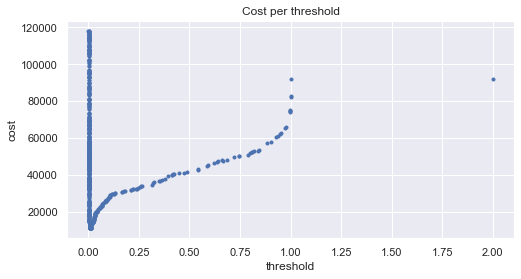

In [15]:
# Optimizing LogisticRegression thresholds

logit_clf = pickle.load(open('logit_clf.pkl', 'rb'))

scores = logit_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

min_cost = np.inf
best_threshold = 0.5
costs = []
for threshold in tqdm(thresholds):
    y_pred_threshold = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold
print("Best threshold: {:.4f}".format(best_threshold))
print("Min cost: {:.2f}".format(min_cost))

plt.figure(figsize=(8,4))
plt.scatter(x=thresholds, marker='.', y=costs)
plt.title('Cost per threshold')
plt.xlabel('threshold')
plt.ylabel('cost')
plt.show()

## Model Validation on Test Set
1. Finally, using RandomForest model, validate on test set data.
2. Achieved 0.9863 accuracy with 6110 challenge metric.

In [16]:
# transform target class to binary
df_test['class'] = LabelEncoder().fit_transform(df_test['class'].values)

# drop highly correlated features
df_test.drop(columns = high_cor, inplace = True)

# drop predictors with >70% missing values
df_test.drop(columns = set(missing_predictor[missing_predictor.values > 0.7].index.values) - set(high_cor), inplace = True)

# impute missing with median values
imp_df_test = imp_mean.transform(df_test)
df_test = pd.DataFrame(imp_df_test, columns = df_test.columns)

# select top features
X, y = df_test.loc[:,top_features], df_test.loc[:,'class']

# scale data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [17]:
helper_clf = pickle.load(open('rf_clf.pkl', 'rb'))
y_pred = helper_clf.predict(X)

roc_score = metrics.roc_auc_score(y, y_pred)
acu_score = metrics.accuracy_score(y, y_pred)
chal_score = cal_metric(y, y_pred)

train_test_result = train_test_result.append(pd.DataFrame([(helper_clf.best_estimator_, helper_clf.best_params_, 
                                        helper_clf.best_score_, roc_score, acu_score, chal_score)],                                      
                                        columns = ['Best Estimator', 'Best Params', 'Best Score', 'Test ROC', 
                                                   'Test Accuracy','Test Challenge Metric']))

print('Test ROC : {}, Test Accuracy : {}, Test Challenge Metric : {}'.format(roc_score, acu_score, chal_score))

Test ROC : 0.7184106666666668, Test Accuracy : 0.9863125, Test Challenge Metric : 6110
